# **Mandelbrot Neural Network**
By Wes Jones

### **Intro**

In this following notebook, I will be exploring the use of Neural Networks to predict the Mandelbrot set. To do this I will be generating data using python. Then I will train different models on the data and see how well a network can learn the Mandelbrot.

I chose this as my project because I wanted to do something outside of the box. There was very little online about doing this and I was happy to find something new. I also really find the mandelbrot set and choas theory really interesting. So I decided combnining my new ML skills and the mandelbrot would be super fun!

### **Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader, TensorDataset

Code given from Google Colab that shows GPU information

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 11 20:16:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Data Generation**


In this cell I define my methods for data generation. This code was adapted from a personal mandelbrot project. I believe that I originally based it off a Stack Overflow thread. The first two methods are used for generating general mandelbrot points. This code generates all of the testing data, and some of the training data. How it works is it generates random points and runs them through 1000 iterations to see if the point converges or diverges.  The last four methods are for generating points along the edge. This works very similarly to the first two functions. Except these only find data along the edge. This is done by generating a random point and checking points that are *delta* away from the original point. For example in is_converge_edge the method checks to see if one of the neighbors is a divergent point. If so it is appended to the list in mandelbrot_conv_edge_points. The thickness of the data around the edge can be adjusted by changing the *delta* value. Once complete the function returns a 2d float Numpy Array with columns of [real, imaginary, convergence]. 1 indicates convergence while 0 indicates divergence.


Interesting note on this code. The way I generate these edge points is very inefficient. Say I wanted to generate just 100,000 points(50,000 for each side). For each point I would have to check for convergence (1000 iterations). Then in the worst case I would have to check each neighbor. This would require 1000x4 iterations. And each iteration computes the new z value (2 computations) and then checks if it is larger than 2 (1 computation).  So doing some math it would take 5,000 x 3 x 100,000 = 1,500,000,000 computations just on the iterations alone. But this assumes that it only randomly generated points that actually lay on the edge. Because the points are randomly generated, most points generated wont be counted in the final data. So the number of computations is actually much much larger. There is probably a more efficient way to do this but that is not the goal of this project


In [ ]:
def mandelbrot_points(n):

    points = np.empty((n, 3), dtype=np.float64)
    i = 0
    while i < n:
        real = random.uniform(-1.5, .5)
        imaginary = random.uniform(-1, 1)
        c = complex(real, imaginary)
        converges = is_mandelbrot(c)

        if converges:
            points[i, :] = [real, imaginary, 1]
        else:
            points[i, :] = [real, imaginary, 0]
        i += 1

    return points

def is_mandelbrot(c):
    z = 0
    for i in range(1000): #Iterations
        z = z * z + c
        if abs(z) > 2:
            return False
    return True

def mandelbrot_conv_edge_points(n):
    points = np.empty((n, 3), dtype=np.float64)
    i = 0
    while i < n:
        real = random.uniform(-1.5, .5)
        imaginary = random.uniform(-1, 1)
        c = complex(real, imaginary)

        if is_converge_edge(c):
            points[i, :] = [real, imaginary, 1]
            i += 1


    return points

def is_converge_edge(c):
    converges = is_mandelbrot(c)
    if not converges:
        return False

    delta = 0.01  #edge thickness
    neighbors = [
        complex(c.real + delta, c.imag),
        complex(c.real - delta, c.imag),
        complex(c.real, c.imag + delta),
        complex(c.real, c.imag - delta)
    ]

    for neighbor in neighbors:
        if not is_mandelbrot(neighbor):
            return True

    return False

def mandelbrot_div_edge_points(n):
    points = np.empty((n, 3), dtype=np.float64)
    i = 0
    while i < n:
        real = random.uniform(-1.5, .5)
        imaginary = random.uniform(-1, 1)
        c = complex(real, imaginary)

        if is_diverge_edge(c):
            points[i, :] = [real, imaginary, 0]
            i += 1


    return points

def is_diverge_edge(c):
    converges = is_mandelbrot(c)
    if converges:
        return False

    delta = 0.01  #edge thickness
    neighbors = [
        complex(c.real + delta, c.imag),
        complex(c.real - delta, c.imag),
        complex(c.real, c.imag + delta),
        complex(c.real, c.imag - delta)
    ]

    for neighbor in neighbors:
        if is_mandelbrot(neighbor):
            return True

    return False


### **Display**

This method uses Matpltlib to plot the data. It colors convergent points as red while divergent points as black.

In [ ]:
def display(points):
    x_black = [point[0] for point in points if point[2] == 0]
    y_black = [point[1] for point in points if point[2] == 0]

    x_white = [point[0] for point in points if point[2] == 1]
    y_white = [point[1] for point in points if point[2] == 1]

    plt.figure(figsize=(12,12))
    point_size=.1

    plt.scatter(x_black, y_black, marker='.', color='black', s=point_size)
    plt.scatter(x_white, y_white, marker='.', color='red', s=point_size)
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.show()

### **Testing Data**

In this cell I specify how many points I want to generate for testing. 6,000,000 points was chosen because it will fill in the graph enough so there isnt whitespace.

In [ ]:
n = 6000000 #6,000,000
data = mandelbrot_points(n)
print(data)

[[-1.45992216  0.73939502  0.        ]
 [-0.5252506  -0.02968321  1.        ]
 [-0.69243395  0.85510296  0.        ]
 ...
 [-1.46678851 -0.35126264  0.        ]
 [ 0.24147177  0.52061475  1.        ]
 [-0.39627513  0.21327391  1.        ]]


In [ ]:
display(data)

### **Training Data**

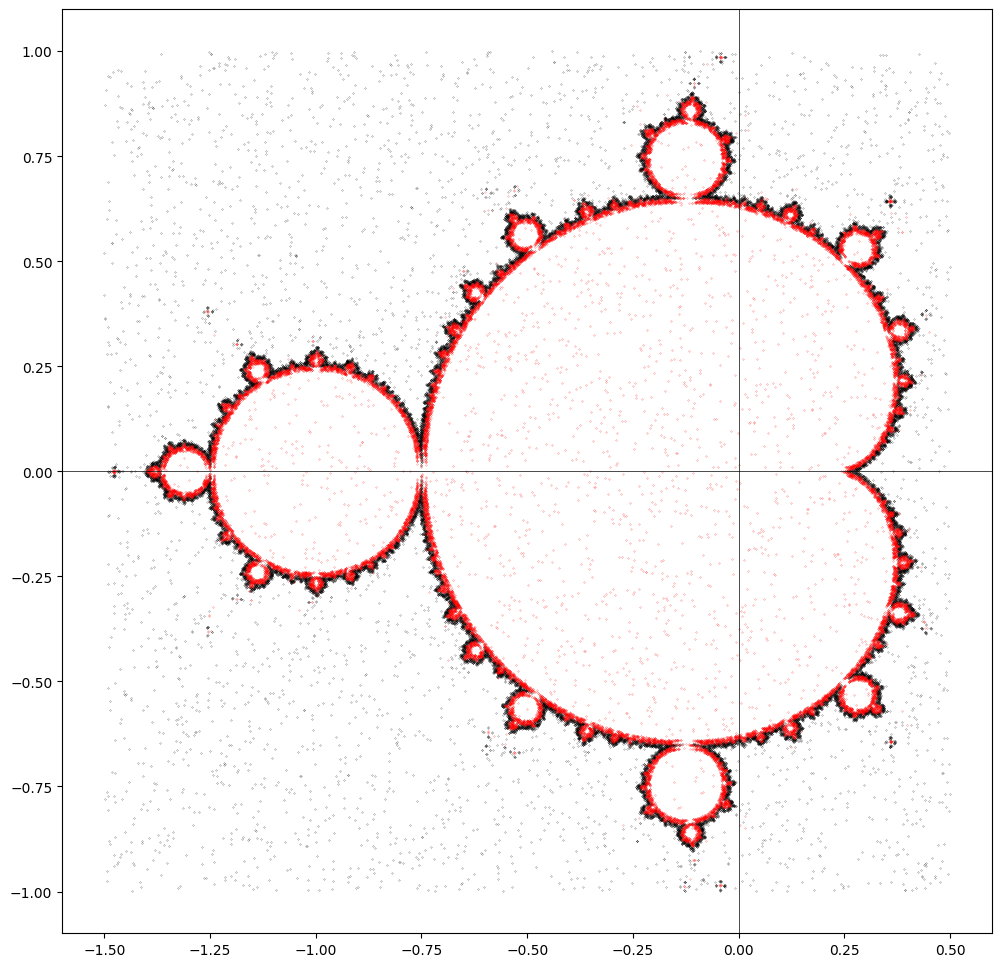

In [ ]:
Converge_data = mandelbrot_conv_edge_points(30000) #30,000
Diverge_data = mandelbrot_div_edge_points(30000) #30,000
pool_data = mandelbrot_points(5000) #5,000

data_v2 = np.concatenate((Diverge_data, Converge_data, pool_data)) #65,000 total points
display(data_v2)

### **Pytorch Class Decleration**

This cell is where I declare my Neruel Netowrk using Pytorch. This code was addapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, other online tutorials, and help with my grad student roomate. I used Relu as my activation function and Adam as my optimizer.

My network will have an input of two parameters, an x and y coordinate and have a output of 2, a probabilty of either convergence or divergence. I then used a softmax function to turn these probabilites into a chosen class.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size):
        super().__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, layer_sizes[0]))

        # Hidden layers
        for i in range(1, len(layer_sizes)):
            self.layers.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))

        # Output layer
        self.layers.append(nn.Linear(layer_sizes[-1], output_size))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = F.relu(layer(x))
            else:
                x = layer(x)  # Return the logits without applying the softmax
        return x

    def train(self, X_train, T_train, epochs, lr, device, batch_size=32):
      train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(T_train, dtype=torch.long).squeeze())
      train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

      self.to(device)

      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(self.parameters(), lr=lr)

      running_losses = []

      for epoch in range(epochs):  # loop over the dataset multiple times
          running_loss = 0.0
          for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

              # zero the parameter gradients
            optimizer.zero_grad()

              # forward + backward + optimize
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

          running_losses.append(running_loss / len(train_dataloader))


      print('Finished Training')
      self.plot_error(running_losses)

    def plot_error(self, running_losses):
        plt.plot(running_losses)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.show()


### **DataPrep**

In this cell I parse the data into inputs and labels

In [ ]:
def DataPrep(data):

    T = data[:,2]
    X = data[:,:-1]
    T = T.reshape(-1, 1)

    return X, T


In [ ]:
X_Test, T_Test = DataPrep(data)

print("X Training data: ", X_Test.shape)
print("T Testing data: ", T_Test.shape)

X Training data:  (6000000, 2)
T Testing data:  (6000000, 1)


### **GPU Acceleration**

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


# **Attempt 1**
*   6 layers of 25 nodes
*   Learning rate of .0001
*   50 Epochs

In [ ]:
X_Train_1, T_Train_1 = DataPrep(data_v2)

start_1 = time.time()
input_size_1 = 2
layer_sizes_1 = [25, 25, 25, 25, 25, 25]
output_size_1 = 2

epochs_1 = 50
lr_1 = .0001
batch_size = 5000

net_1 = Net(input_size_1, layer_sizes_1, output_size_1)
net_1.train(X_Train_1, T_Train_1, epochs_1, lr_1, device, batch_size)

elapsed_1 = ((time.time() - start_1) / 60)
print("Trained in", elapsed_1, "mins")

X_Test_1 = torch.tensor(X_Test, dtype=torch.float).to(device)
outputs_1 = net_1(X_Test_1)
pred_1 = np.argmax(outputs_1.detach().cpu().numpy(), axis=1).reshape(-1, 1)

#Hstack data[:,:-1] with pred
result_1 = np.hstack((X_Test, pred_1))

pred_1 = pred_1.reshape(-1)
pred_1 = pred_1 != 0

actual = np.array(T_Test)
actual = actual.flatten()
actual = actual != 0

accuracy_1 = (100 * np.mean(pred_1 == actual))
print("Final Accuracy: ", accuracy_1)
torch.cuda.empty_cache()

Finished Training


Trained in 0.6742736061414083 mins
Final Accuracy:  92.42656666666666


In [ ]:
display(result_1)


### **Attempt 1 Discussion**


For the first attempt I went with a small network and a modest amount of epochs. The final result wasn't very good. The shape looks like a blob and nothing like the mandelbrot. By looking at the loss graph. It looks like I could have ran this for more epochs to get a better result. But for a network that only trained in 30 seconds. I would say that an accuracy of 92% is pretty good. But it lacks the detail that I want to see.


### **Attempt 2**



*   3 layers of 50 nodes
*   .0001 Learning Rate
*   300 Epochs



In [ ]:
X_Train_2, T_Train_2 = DataPrep(data_v2)

start_2 = time.time()
input_size_2 = 2
layer_sizes_2 = [50, 50, 50]
output_size_2 = 2

epochs_2 = 300
lr_2 = .0001
batch_size = 5000

net_2 = Net(input_size_2, layer_sizes_2, output_size_2)
net_2.train(X_Train_2, T_Train_2, epochs_2, lr_2, device, batch_size)

elapsed_2 = ((time.time() - start_2) / 60)
print("Trained in", elapsed_2, "mins")

X_Test_2 = torch.tensor(X_Test, dtype=torch.float).to(device)
outputs_2 = net_2(X_Test_2)
pred_2 = np.argmax(outputs_2.detach().cpu().numpy(), axis=1).reshape(-1, 1)

#Hstack data[:,:-1] with pred
result_2 = np.hstack((X_Test, pred_2))

pred_2 = pred_2.reshape(-1)
pred_2 = pred_2 != 0

actual = np.array(T_Test)
actual = actual.flatten()
actual = actual != 0

accuracy_2 = (100 * np.mean(pred_2 == actual))
print("Final Accuracy: ", accuracy_2)
torch.cuda.empty_cache()


Finished Training


Trained in 0.8508247375488281 mins
Final Accuracy:  93.72735


In [ ]:
display(result_2)

### **Attempt 2 Discussion**

For this network I wanted to try a larger network with more epochs. This network trained in only .8 mins and had a final accuracy of 93%. This accuracy was pretty good, but it looks like this network could train for a few more epochs. The result was a better looking mandelbrot. This means that I am moving in the right direction with larger networks and more epochs.

### **Attempt 3**
*   3 Layers of 100 nodes
*   .0001 Learning Rate
*   150 Epochs

Finished Training


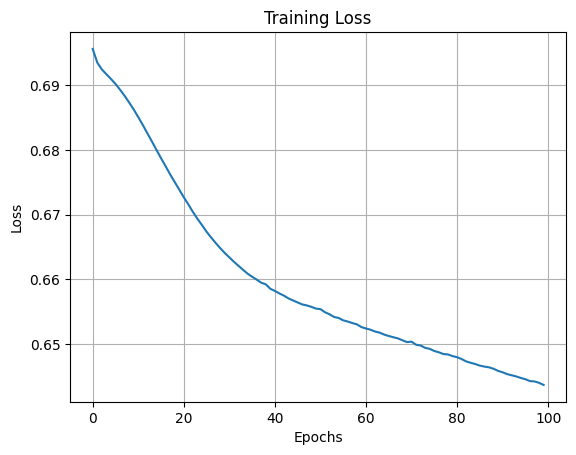

Trained in 1.1314751625061035 mins
Final Accuracy:  95.93005


In [ ]:
X_Train_3, T_Train_3 = DataPrep(data_v2)

start_3 = time.time()
input_size_3 = 2
layer_sizes_3 = [100, 100, 100]
output_size_3 = 2

epochs_3 = 150
lr_3 = .0001
batch_size = 5000

net_3 = Net(input_size_3, layer_sizes_3, output_size_3)
net_3.train(X_Train_3, T_Train_3, epochs_3, lr_3, device, batch_size)

elapsed_3 = ((time.time() - start_3) / 60)
print("Trained in", elapsed_3, "mins")

X_Test_3 = torch.tensor(X_Test, dtype=torch.float).to(device)
outputs_3 = net_3(X_Test_3)
pred_3 = np.argmax(outputs_3.detach().cpu().numpy(), axis=1).reshape(-1, 1)

#Hstack data[:,:-1] with pred
result_3 = np.hstack((X_Test, pred_3))

pred_3 = pred_3.reshape(-1)
pred_3 = pred_3 != 0

actual = np.array(T_Test)
actual = actual.flatten()
actual = actual != 0

accuracy_3 = (100 * np.mean(pred_3 == actual))
print("Final Accuracy: ", accuracy_3)
torch.cuda.empty_cache()


In [ ]:
display(result_3)

### **Attempt 3 Discussion**
For this attempt I wanted to continue the trend of larger networks and more epochs. This network had 3 layers of 100 nodes, 150 epochs, and a learning rate of .0001. This network was trained in only a min and had an accuracy of 95%. This was the first network to be able to produce a shape that was somewhat a mandelbrot. It looks like the larger networks with more epochs are doing better and capturing more detail


For the next network, I wanted to do a larger network with a lower learning rate to hopefully capture more detail.


### **Attempt 4**
*   5 Layers of 100 Nodes
*   .00001 Learning Rate
*   2000 Epochs

In [ ]:
X_Train_4, T_Train_4 = DataPrep(data_v2)

start_4 = time.time()
input_size_4 = 2
layer_sizes_4 = [100, 100, 100, 100, 100]
output_size_4 = 2

epochs_4 = 2000
lr_4 = .00001
batch_size = 5000

net_4 = Net(input_size_4, layer_sizes_4, output_size_4)
net_4.train(X_Train_4, T_Train_4, epochs_4, lr_4, device, batch_size)

elapsed_4 = ((time.time() - start_4) / 60)
print("Trained in", elapsed_4, "mins")

X_Test_4 = torch.tensor(X_Test, dtype=torch.float).to(device)
outputs_4 = net_4(X_Test_4)
pred_4 = np.argmax(outputs_4.detach().cpu().numpy(), axis=1).reshape(-1, 1)

#Hstack data[:,:-1] with pred
result_4 = np.hstack((X_Test, pred_4))

pred_4 = pred_4.reshape(-1)
pred_4 = pred_4 != 0

actual = np.array(T_Test)
actual = actual.flatten()
actual = actual != 0

accuracy_4 = (100 * np.mean(pred_4 == actual))
print("Final Accuracy: ", accuracy_4)
torch.cuda.empty_cache()

Finished Training


Trained in 12.211823264757792 mins
Final Accuracy:  96.23296666666667


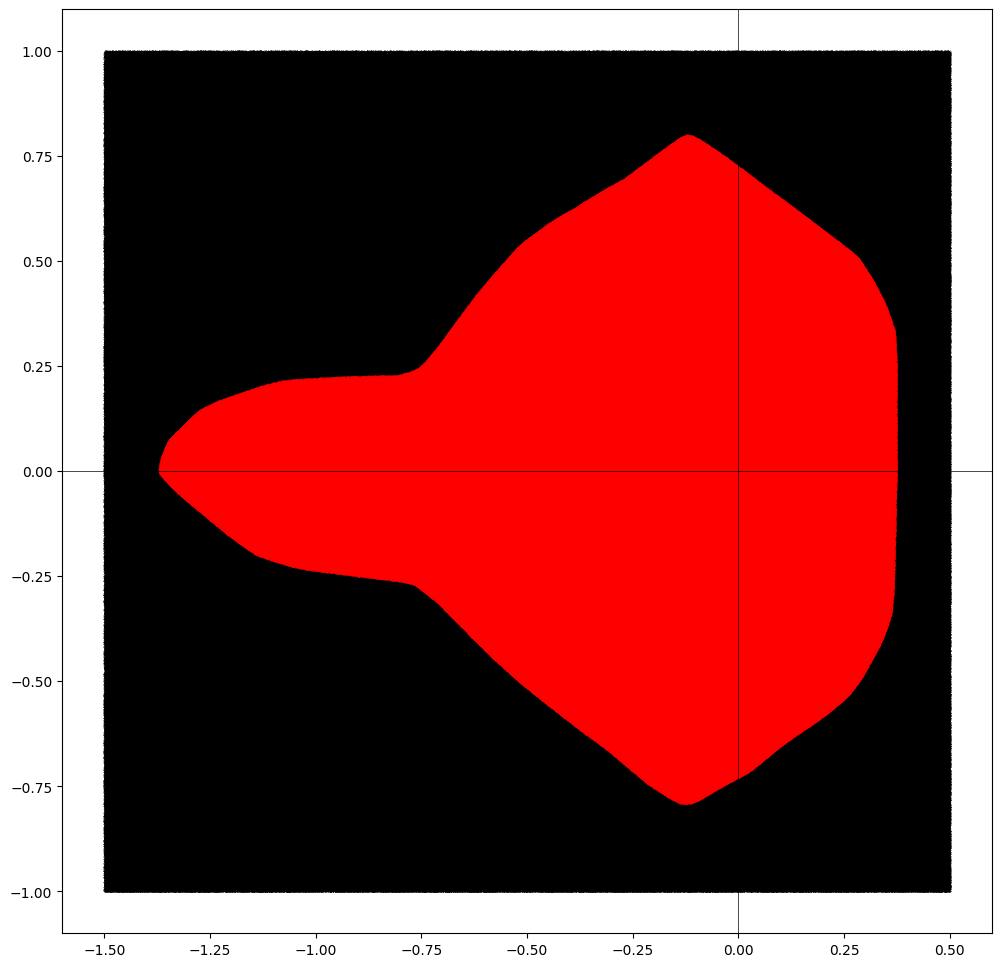

In [ ]:
display(result_4)

### **Attempt 4 Discussion**

This network had 5 layers of 100 nodes, a learning rate of .00001 with 2000 epochs. This network was trained in 12 min and had a final accuracy of 96%. This was an improvement from the last network. But the result still wasn't as detailed as I wanted. This was interesting because the last network had a better shape than this network. I think this was because of the lower learning rate. I still havent had a model converge. This means that I am not doing enough epochs for the networks to converge. For the next network, I am going to add another layer of 100 layers and add another 3000 epochs.

### **Attempt 5**
*   6 Layers of 100 Nodes
*   .00001 Learning Rate
*   5000 Epochs


Finished Training


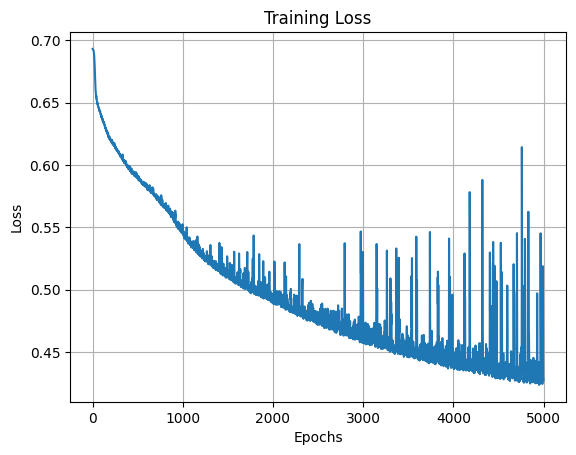

Trained in 51.01501784324646 mins
Final Accuracy:  98.8351


In [ ]:
X_Train_5, T_Train_5 = DataPrep(data_v2)

start_5 = time.time()
input_size_5 = 2
layer_sizes_5 = [100, 100, 100, 100, 100, 100]
output_size_5 = 2

epochs_5 = 5000
lr_5 = .00001
batch_size = 10000

net_5 = Net(input_size_5, layer_sizes_5, output_size_5)
net_5.train(X_Train_5, T_Train_5, epochs_5, lr_5, device, batch_size)

elapsed_5 = ((time.time() - start_5) / 60)
print("Trained in", elapsed_5, "mins")

X_Test_5 = torch.tensor(X_Test, dtype=torch.float).to(device)
outputs_5 = net_5(X_Test_5)
pred_5 = np.argmax(outputs_5.detach().cpu().numpy(), axis=1).reshape(-1, 1)

#Hstack data[:,:-1] with pred
result_5 = np.hstack((X_Test, pred_5))

pred_5 = pred_5.reshape(-1)
pred_5 = pred_5 != 0

actual = np.array(T_Test)
actual = actual.flatten()
actual = actual != 0

accuracy_5 = (100 * np.mean(pred_5 == actual))
print("Final Accuracy: ", accuracy_5)
torch.cuda.empty_cache()

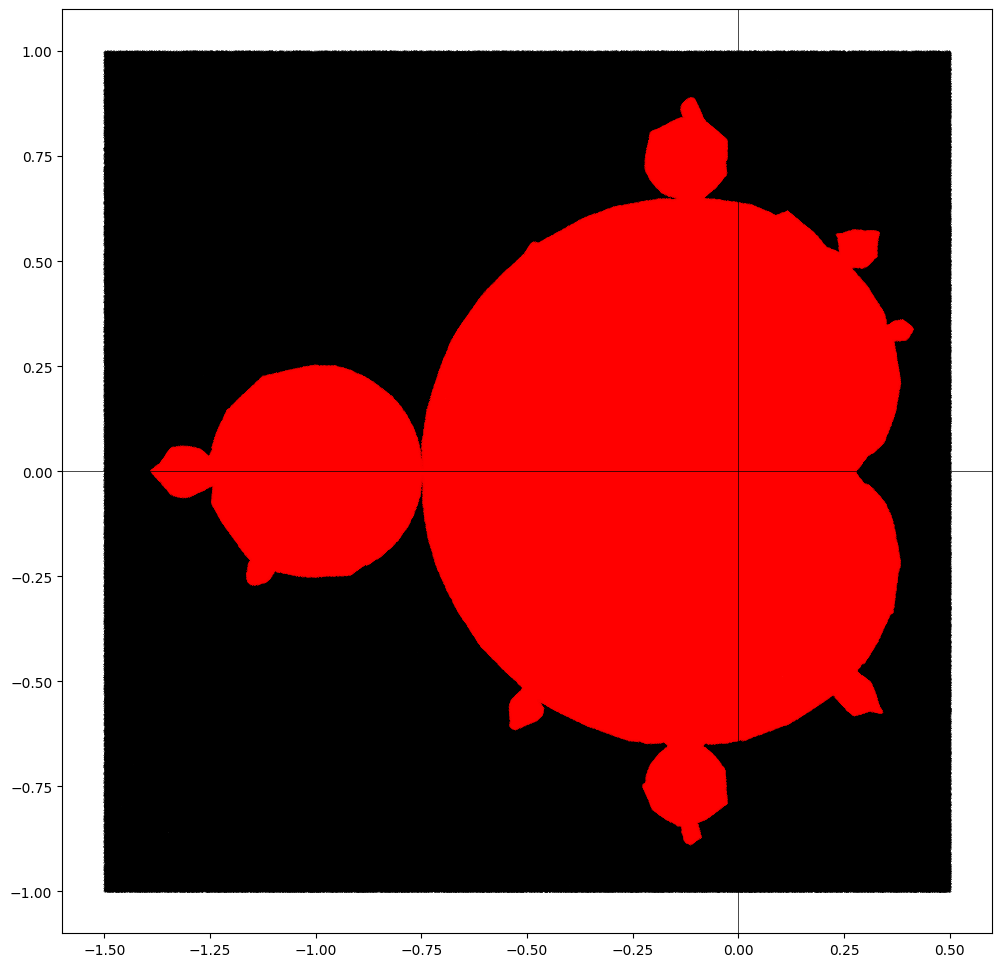

In [ ]:
display(result_5)

### **Attempt 5 Discussion**

For this network, I wanted to keep the bigger network and more epochs trend. This proved to be a good decision. This network had 6 layers of 100 nodes, a learning rate of .00001. This network was trained in 51 min and had a final accuracy of 98%. I was really happy with the result of this network! The result was a shape that was undeniably the mandelbrot. I was super happy with this result and was about to stop here. But by looking at the loss graph, I saw that the loss was bouncing around a lot at the end. This means that I had finally started to converge, but my learning rate was too high. So I wanted to try and push it further to see what I could get.

Because of a problem with the GPU maxing out during the use function, I decided to lower the amount of data I was testing on. Below I declare a new set of testing data with only 1.5 million points. While this amount of data does cause static to show up in the final image, it swallowed my OCD and decided it was better than a "CUDA out of Memory" error.

In [ ]:
data_v3 = mandelbrot_points(1500000)
X_Test, T_Test = DataPrep(data_v3)


### **Attempt 6**
*   6 Layers of 100 Nodes
*   .000005 Learning Rate
*   10000 Epochs

In [ ]:
X_Train_8, T_Train_8 = DataPrep(data_v2)

start_8 = time.time()
input_size_8 = 2
layer_sizes_8 = [100, 100, 100, 100, 100, 100]
output_size_8 = 2

epochs_8 = 10000
lr_8 = .000005
batch_size = 10000

net_8 = Net(input_size_8, layer_sizes_8, output_size_8)
net_8.train(X_Train_8, T_Train_8, epochs_8, lr_8, device, batch_size)

elapsed_8 = ((time.time() - start_8) / 60)
print("Trained in", elapsed_8, "mins")

X_Test_8 = torch.tensor(X_Test, dtype=torch.float).to(device)
outputs_8 = net_8(X_Test_8)
pred_8 = np.argmax(outputs_8.detach().cpu().numpy(), axis=1).reshape(-1, 1)

# Hstack data[:,:-1] with pred
result_8 = np.hstack((X_Test, pred_8))

pred_8 = pred_8.reshape(-1)
pred_8 = pred_8 != 0

actual = np.array(T_Test)
actual = actual.flatten()
actual = actual != 0

accuracy_8 = (100 * np.mean(pred_8 == actual))
print("Final Accuracy:", accuracy_8)
torch.cuda.empty_cache()


Finished Training


Trained in 122.50469483931859 mins
Final Accuracy: 98.28620000000001


In [ ]:
display(result_8)

### **Attempt 6 Disscussion**

For this netowrk, I kept everything the same from attempt 5, but lowered the learning rate to .000005 and trained it for 10,000 epochs. And this paid off. The finaly accuracy was simular to attempt 5 but I felt like the final image was a lot better. This network trained for 122 mins, but still didnt converge. This was disapointing, so for my last try, I went ahead and upped the ante and did 20,000 epochs

### **Final Attempt**
*   6 Layers of 100 Nodes
*   .000005 Learning Rate
*   20000 Epochs


Finished Training


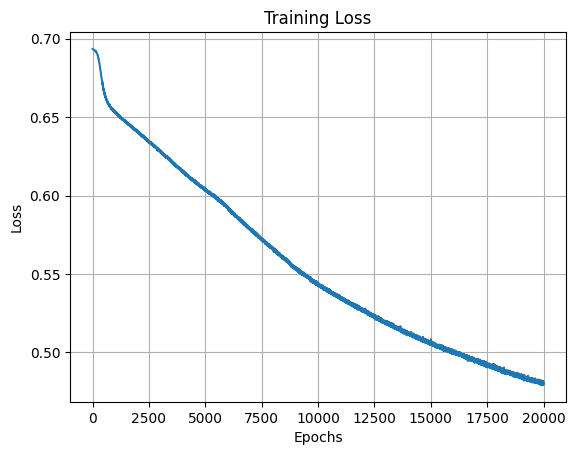

Trained in 266.9454492092133 mins
Final Accuracy: 98.66613333333333


In [ ]:
X_Train_9, T_Train_9 = DataPrep(data_v2)

start_9 = time.time()
input_size_9 = 2
layer_sizes_9 = [100, 100, 100, 100, 100, 100]
output_size_9 = 2

epochs_9 = 20000
lr_9 = .000005
batch_size = 10000

net_9 = Net(input_size_9, layer_sizes_9, output_size_9)
net_9.train(X_Train_9, T_Train_9, epochs_9, lr_9, device, batch_size)

elapsed_9 = ((time.time() - start_9) / 60)
print("Trained in", elapsed_9, "mins")

X_Test_9 = torch.tensor(X_Test, dtype=torch.float).to(device)
outputs_9 = net_9(X_Test_9)
pred_9 = np.argmax(outputs_9.detach().cpu().numpy(), axis=1).reshape(-1, 1)

# Hstack data[:,:-1] with pred
result_9 = np.hstack((X_Test, pred_9))

pred_9 = pred_9.reshape(-1)
pred_9 = pred_9 != 0

actual = np.array(T_Test)
actual = actual.flatten()
actual = actual != 0

accuracy_9 = (100 * np.mean(pred_9 == actual))
print("Final Accuracy:", accuracy_9)
torch.cuda.empty_cache()

In [ ]:
display(result_9)

### **Final Attempt Discussion**

This was my final attempt. This attempt was interesting. I kept the same architecture and learning rate as the last few attempts, but instead this time I upped the epochs to 20,000. This was double what it was in the last attempt. I thought to myself: "This has to be enough". And after waiting for four hours, I was happy, disappointed, and intrigued. I was very happy that I didn't encounter and memory errors and the code executed without problem, but I was disappointed to see that the network still had not converged. This was interesting because I had doubled the epochs. And if you look at the resulting image, its a bit, deformed. I was very excited to see the two points in the middle come together nicely and that it had captured a few bulbs. But I was intrigued on why there are some blobs that lay off of the actual set. After some thinking I think I know why this happened. When I was generating my data, some randomly generated points were classified as converging that are way outside of the set. This is because of the infinite nature of the Mandelbrot. As you zoom in on the boundry you will find that there is an infinite complexity. And those points in the data just so happened to lay in those areas. In the case of this network, It had enough epochs to recognize those points and created blobs to classify them. In a way this could be seen as a type of overfitting. While this is true complexity in the data that in theory should be captured by the Network, It would have performed a lot better if it had just ignored those points. Overall though the loss was still on a downward trajectory and probably could have trained for a lot longer. But seeing how this network took 4 hours to train, I decided to halt further testing here.



### **Project Evolution**

When I started this project I thought that It would be pretty straight forward. I would just generate some points and then train a model on them and display what the network thought the mandelbrot looked like. But this was not the case. This project went through many iterations and most of the work is not displayed in this notebook. Overall I probably trained about 30 models. But as I ran into problems and my code evolved, I deleted most of the models. This was done because I wanted my code to make sense and I didnt want a notebook full of failed cells. Instead I will describe the evolution of this code instead.


My first approach to the problem was generating about 5 million training points and training various networks on that data.  But when I went to train, I found that a network with a small architecture and only 10 epochs would take about an hour and a half to train, and the results were not too good. This was the first evolution of my code. I realized that most of the points I am generating weren't actually aiding in training. Most of the points don't lay anywhere near the edge. To fix this, I defined a few new functions that only generated points on the edge. Then I used the normal generation function to create "pool" data. I then combined these two sets of data to create a better data set. This final set consisted of mostly edge points and only a few thousand points to fill in the gaps elsewhere. This allowed for my networks to train on more useful data. This was a huge benefit to the training of my networks. The same networks that took an hour to train now only took 10 mins. This allowed me to scale up even bigger networks.


The other thing that I changed was the application of batching. While I was running my experiments I ran into a recurring problem. This was that my network would train and then the GPU would run out of memory when I went to use it. I edited the NN class to use batching and this helped significantly.


A few other evolutions were the colors of the mandelbrot points, how my network calculated and displayed the loss, the size of the graphs, how I computed accuracy, and the amount of data I trained and tested on.

I also ended up running my project on google colab. This was a huge help because I wasnt competing for resources on the school machines. I didnt mind paying for it because I was interested in what I was doing and I have a job for a reason


Overall it took me many hours of trial and error to get the notebook to present in a way that I was happy with.




### **Conclusion**

While doing this project I learned some interesting things. While training a neural network on the mandelbrot is somewhat trivial and there's not much real world applications for such a network, I still think it was super interesting. Because I was training on a mathematical formula, my access to data was unlimited (for better or for worse). After hearing the ethics talk in class, I know that the biggest hurdle in training a accurate model is the quality of the data. Luckily because my data was simple and infinite, I did not have to struggle with problems such as class inequality, noise, or lack of data.

 Another interesting caveat I found was that of overfitting. The entire project I thought "I cant overfit my networks". This was because there was virtually no noise in my data and all complexity that the network could find is true complexity that should be captured. But After training my last network, I learned that that's not necessarily true. Because of the infinite complexity of the mandelbrot, there are convergent points in a sea of divergent points. Even though I thought this wasn't possible, looking at it now, I can see how my networks could overfit the Mandelbrot.

On another note, the mandelbrot is infinitely complex. This means that there is no true boundary between convergence and divergence. Given that there is no true boundary, I was happy with the way my larger networks performed. The accuracy was super high from the start, but it wasn't till I reached the larger networks that I started to see the true shape of the mandelbrot come out. Much like the infinite computing power that is required to fully capture its complexity, It would take an even larger infinity to train a network to fully capture its complexity.

While doing some research later into my project, I found that there is a way to represent mandelbrot points as fourier features as opposed to x,y coordinates. Theoretically I could use these as inputs to my network. This would have been super interesting because I would have been able to increase the dimensionality of my networks. And in turn might be able to capture more complexity of the set than the standard x,y coordinates. I would have loved to try this out for my project, but the math involved in generating these kinds of points goes over my head. Maybe in the future I will attempt something like this.

Overall I had a lot of fun doing this project. Even though this project took a lot of time, thinking, and money, I enjoyed every second of it. I always enjoyed running back to my computer to see what my network had made, even if it was a "CUDA out of Memory" error. I hope my excitement and passion was reflected in this project!


